In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Đọc dữ liệu
df = pd.read_excel("Online Retail.xlsx")
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
# Xóa dòng thiếu CustomerID hoặc dữ liệu âm
df.dropna(subset=["CustomerID"], inplace=True)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

In [4]:
# Chuyển InvoiceDate về kiểu datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Tính giá trị tiền
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [5]:
# Ngày tham chiếu để tính Recency
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [6]:
# Tính RFM
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

# Ép kiểu integer
rfm['CustomerID'] = rfm['CustomerID'].astype(int)
rfm['Recency']    = rfm['Recency'].astype(int)
rfm['Frequency']  = rfm['Frequency'].astype(int)

# Làm tròn Monetary về 2 chữ số thập phân
rfm['Monetary']   = rfm['Monetary'].round(2)

rfm[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266459
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


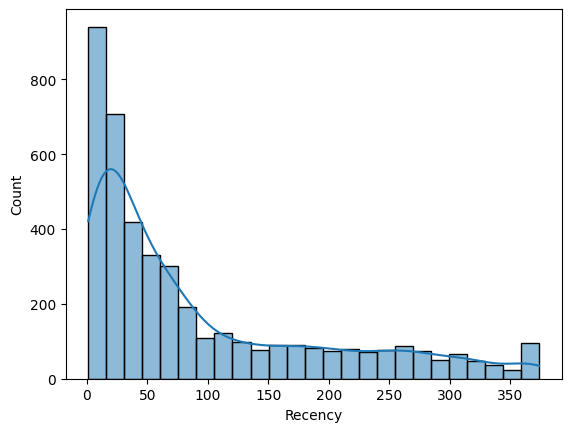

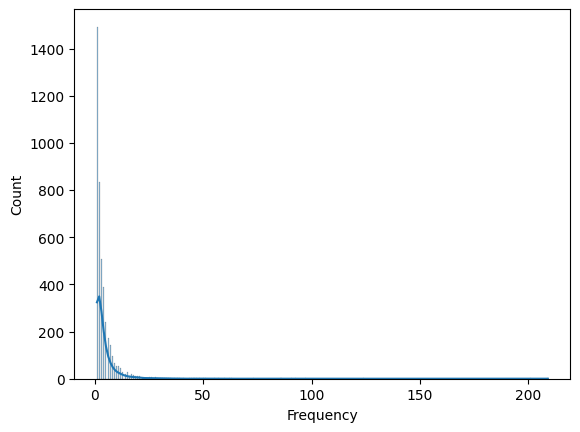

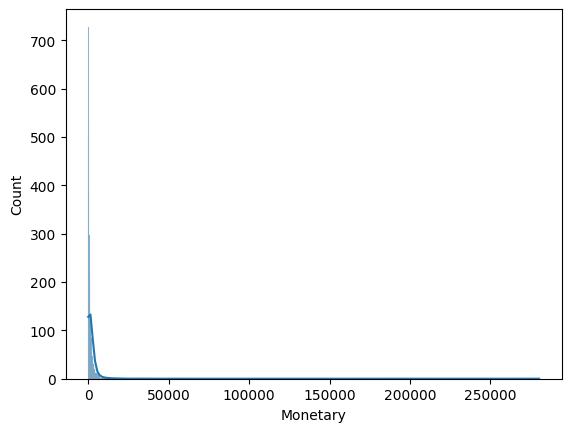

In [7]:
# Trực quan hóa RFM
sns.histplot(rfm['Recency'], kde=True)
plt.show()
sns.histplot(rfm['Frequency'], kde=True)
plt.show()
sns.histplot(rfm['Monetary'], kde=True)
plt.show()

In [8]:
# Log transformation giúp giảm bớt độ lệch của RFM trước khi chuẩn hóa
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log']  = np.log1p(rfm['Monetary'])
rfm['Recency_log']   = np.log1p(rfm['Recency'])

print(rfm.head())

   CustomerID  Recency  Frequency  Monetary  Frequency_log  Monetary_log  \
0       12346      326          1  77183.60       0.693147     11.253955   
1       12347        2          7   4310.00       2.079442      8.368925   
2       12348       75          4   1797.24       1.609438      7.494564   
3       12349       19          1   1757.55       0.693147      7.472245   
4       12350      310          1    334.40       0.693147      5.815324   

   Recency_log  
0     5.789960  
1     1.098612  
2     4.330733  
3     2.995732  
4     5.739793  


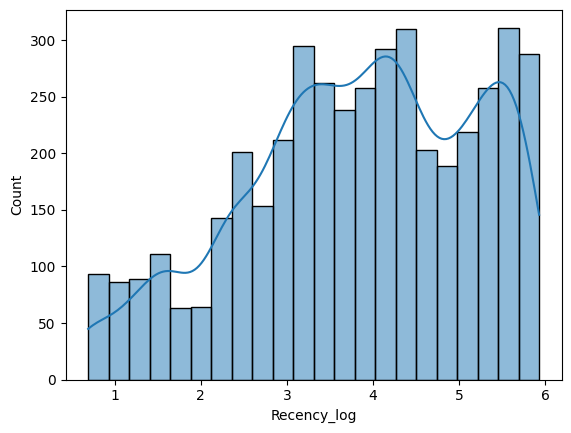

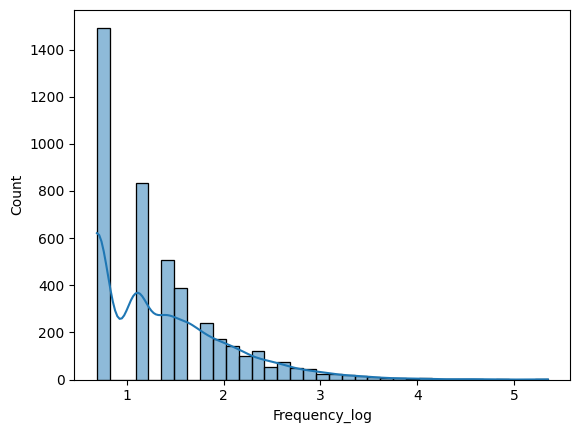

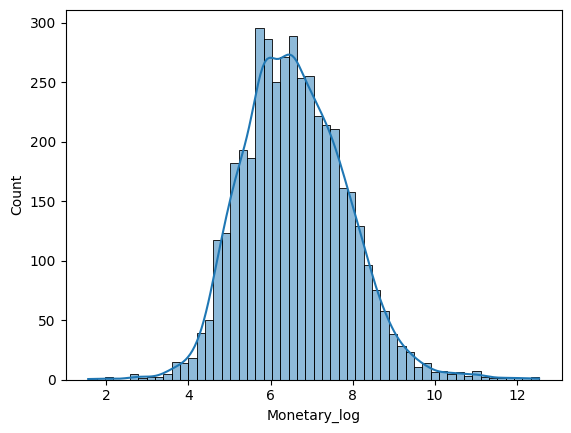

In [9]:
# Trực quan hóa RFM sau khi log transformation
sns.histplot(rfm['Recency_log'], kde=True)
plt.show()
sns.histplot(rfm['Frequency_log'], kde=True)
plt.show()
sns.histplot(rfm['Monetary_log'], kde=True)
plt.show()

In [10]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
rfm[['Recency_z', 'Frequency_z', 'Monetary_z']] = scaler.fit_transform(rfm[['Recency_log','Frequency_log','Monetary_log']])
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary  Frequency_log  Monetary_log  \
0       12346      326          1  77183.60       0.693147     11.253955   
1       12347        2          7   4310.00       2.079442      8.368925   
2       12348       75          4   1797.24       1.609438      7.494564   
3       12349       19          1   1757.55       0.693147      7.472245   
4       12350      310          1    334.40       0.693147      5.815324   

   Recency_log  Recency_z  Frequency_z  Monetary_z  
0     5.789960   1.461993    -0.955214    3.706225  
1     1.098612  -2.038734     1.074425    1.411843  
2     4.330733   0.373104     0.386304    0.716489  
3     2.995732  -0.623086    -0.955214    0.698739  
4     5.739793   1.424558    -0.955214   -0.618962  


In [11]:
# Áp dụng KMeans có sẵn trong sklearn
k = 3  # số cụm mong muốn

kmeans = KMeans(n_clusters=k, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm[['Recency_z','Frequency_z','Monetary_z']])
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary  Frequency_log  Monetary_log  \
0       12346      326          1  77183.60       0.693147     11.253955   
1       12347        2          7   4310.00       2.079442      8.368925   
2       12348       75          4   1797.24       1.609438      7.494564   
3       12349       19          1   1757.55       0.693147      7.472245   
4       12350      310          1    334.40       0.693147      5.815324   

   Recency_log  Recency_z  Frequency_z  Monetary_z  Cluster  
0     5.789960   1.461993    -0.955214    3.706225        0  
1     1.098612  -2.038734     1.074425    1.411843        1  
2     4.330733   0.373104     0.386304    0.716489        0  
3     2.995732  -0.623086    -0.955214    0.698739        0  
4     5.739793   1.424558    -0.955214   -0.618962        2  


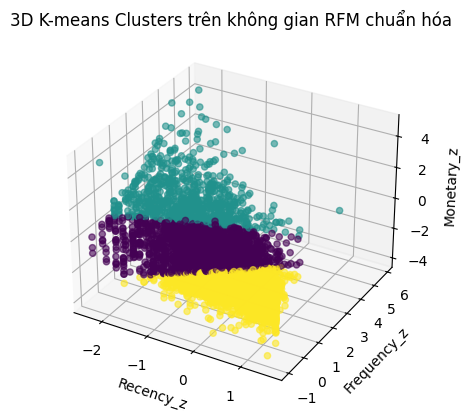

In [12]:
# Trực quan hóa phân cụm khách hàng 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    rfm['Recency_z'], 
    rfm['Frequency_z'], 
    rfm['Monetary_z'], 
    c=rfm['Cluster'], 
    alpha=0.6
)
ax.set_xlabel('Recency_z')
ax.set_ylabel('Frequency_z')
ax.set_zlabel('Monetary_z')
ax.set_title('3D K-means Clusters trên không gian RFM chuẩn hóa')
plt.show()